## 1. Классификация твитов: Trump vs. Trudeau
<p>А как насчет классифицировать тексты твитов? В этом блокноте рассмотрим классификацию текстов в социальных сетях, исследуя, как правильно классифицировать твиты двух известных североамериканских политиков: Дональда Трампа и Джастина Трюдо.</p>
<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference%2C_February_13%2C_2017.jpg/800px-President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference%2C_February_13%2C_2017.jpg" alt="Donald Trump and Justin Trudeau shaking hands." height="100" width="180"></p>
<p><a href="https://commons.wikimedia.org/wiki/File:President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference,_February_13,_2017.jpg">Photo Credit: Executive Office of the President of the United States</a></p>
<p>Твиты создают проблемы при обработке естественного языка, так как они являются более короткими текстами и существует также множество платформенно-специфичных соглашений, которые могут доставить проблемы: упоминания, #хэштеги, эмодзи, ссылки и сокращенные фразы ... Как преодолеть эти проблемы и создать полезный классификатор для этих двух твиттеров?</p>
<p>Для начала мы импортируем все необходимые нам инструменты из scikit-learn. Нам нужно будет правильно векторизовать наши данные (<code>CountVectorizer</code> and <code>TfidfVectorizer</code>). И мы также должны импортировать некоторые модели, включая <code>MultinomialNB</code> from the <code>naive_bayes</code> module, <code>LinearSVC</code> from the <code>svm</code> module and <code>PassiveAggressiveClassifier</code> from the <code>linear_model</code> module. В конце нам понадоятся  <code>sklearn.metrics</code>, <code>train_test_split</code> и <code>GridSearchCV</code>  из модуля <code>model_selection</code> для оценки и оптимизации нашей модели.</p>

<p>

Import CountVectorizer and TfidfVectorizer from sklearn.feature_extraction.text.
Import train_test_split from sklearn.model_selection.
Import MultinomialNB from sklearn.naive_bayes.
Import LinearSVC from sklearn.svm.
Import metrics from sklearn.
</p>

In [ ]:
# Установить для воспроизводимости результатов
import random; random.seed(53)

# Импортируем неообходимые модули из sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

In [ ]:
# это вспомогательные функции для отрисовки диаграмм

from matplotlib import pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure=0):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figure)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_and_return_top_features(classifier, vectorizer, top_features=20):
    """
    Plot the top features in a binary classification model and remove possible overlap.

    Adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    and https://stackoverflow.com/a/26980472 by @kjam
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:top_features]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-top_features:]
    top_coefficients = np.hstack([topn_class1, topn_class2])
    if set(topn_class1).union(topn_class2):
        top_coefficients = topn_class1
        for ce in topn_class2:
            if ce not in topn_class1:
                top_coefficients.append(x)

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in [tc[0] for tc in top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), [tc[0] for tc in top_coefficients], color=colors)
    plt.xticks(np.arange(len(top_coefficients)),
               [tc[1] for tc in top_coefficients], rotation=60, ha='right')
    plt.show()
    return top_coefficients


## 2. Transforming our collected data
<p>Для начала давайте начнем с корпуса твитов, которые были собраны в ноябре 2017 года. Они доступны в формате CSV. Мы будем использовать Pandas DataFrame, чтобы импортировать данные и передать их в scikit-learn для дальнейшей обработки.</p>
<p>Поскольку данные были собраны через API Twitter и не разделены на тестовые и обучающие наборы, нам нужно будет сделать это. Давайте используем <code>train_test_split()</code> с параметром  <code>random_state=53</code> и размером тестовой выборки равной 0.33. Это гарантирует, что у нас будет достаточно тестовых данных, и мы получим одинаковые результаты независимо от того, где и когда мы запустим этот код..</p>
<p>
Данные расположенны в папке dataset файл tweets.csv
</p>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Загрузите данные
tweet_df = pd.read_csv('tweets.csv', encoding="utf-8")

# Выведите названия столбцов, чтобы проверить их
print(tweet_df.columns)

# Укажите правильные столбцы для текста и целевой переменной
y = tweet_df['author']  # Целевая переменная (Трамп или Трюдо)
X = tweet_df['status']  # Текст твитов

# Разделите данные на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

# Проверьте размеры выборок
print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Index(['id', 'author', 'status'], dtype='object')
Размер обучающей выборки: (268,)
Размер тестовой выборки: (132,)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализация TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Векторизация обучающей и тестовой выборок
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Проверка размеров векторизованных данных
print("Размер векторизованной обучающей выборки (TF-IDF):", X_train_tfidf.shape)
print("Размер векторизованной тестовой выборки (TF-IDF):", X_test_tfidf.shape)

Размер векторизованной обучающей выборки (TF-IDF): (268, 1823)
Размер векторизованной тестовой выборки (TF-IDF): (132, 1823)


## 3. Векторизация твитов
<p>У нас есть все необходимые данные для обучения и тестирования, но нам нужно создать векторные представления твитов, чтобы применить машинное обучение..</p>
<p>Для этого мы воспользуемся классами <code>CountVectorizer</code> и <code>TfidfVectorizer</code>, которые нам сначала нужно будет подогнать под данные..</p>
<p>Как только это будет завершено, мы сможем начать моделирование с использованием новых векторизованных твитов</p>


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Инициализировать CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Создать векторизированное представление для обучающей и тестовой выборки на основе CountVectorizer
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Инициализировать TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Создать векторизированное представление для обучающей и тестовой выборки на основе TfidfVectorizer
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

## 4. Обучение мультиномиальной наивной байесовской модели
<p>Теперь, когда у нас есть данные в векторизованной форме, мы можем обучить первую модель. Исследуйте с помощью модели Multinomial Naive Bayes оба векторных представления <code>CountVectorizer</code> и <code>TfidfVectorizer</code>. Что будет работать лучше? Почему?</p>
<p>Для оценки точности вывести оценки точности тестовых наборов для обеих моделей.</p>


Обучите и протестируйте байесовские модели с использованием векторов TF-IDF и CountVectorizer, чтобы увидеть, как они работают.


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Создать модель MultinomialNB на основе TF-IDF
tfidf_nb = MultinomialNB()

# Обучить модель на TF-IDF данных
tfidf_nb.fit(tfidf_train, y_train)

# Проверить предсказание модели на тестовых TF-IDF данных
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# Рассчитать точность предсказаний для TF-IDF
tfidf_nb_score = accuracy_score(y_test, tfidf_nb_pred)

# Создать модель MultinomialNB на основе CountVectorizer
count_nb = MultinomialNB()

# Обучить модель на CountVectorizer данных
count_nb.fit(count_train, y_train)

# Проверить предсказание модели на тестовых CountVectorizer данных
count_nb_pred = count_nb.predict(count_test)

# Рассчитать точность предсказаний для CountVectorizer
count_nb_score = accuracy_score(y_test, count_nb_pred)

# Вывести результаты
print('NaiveBayes Tfidf Score: ', tfidf_nb_score)
print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Tfidf Score:  0.9318181818181818
NaiveBayes Count Score:  0.946969696969697


## 5. Оценка нашей модели с использованием Матрицы Несоответствий
<p>Мы видим, что модель TF-IDF работает лучше, чем подход на основе подсчета. Исходя из того, что мы знаем из курса основ НЛП, почему это может быть? Мы знаем, что TF-IDF позволяет уникальным токенам иметь больший вес — возможно, пользователи Twitter используют определенные важные слова, которые их идентифицируют! Давайте продолжим расследование.</p>
<p>Для задач классификации оценка точности не дает полной картины. Лучшая оценка может быть сделана, если мы посмотрим на матрицу Несоответствий, которая показывает количество правильных и неправильных классификаций на основе каждого класса. Мы можем использовать метрики True Positives, False Positives, False Negatives и True Negatives, чтобы определить, насколько хорошо модель справилась с данным классом. Сколько раз Трамп был ошибочно классифицирован как Трюдо?</p>



Confusion matrix, without normalization
Confusion matrix, without normalization


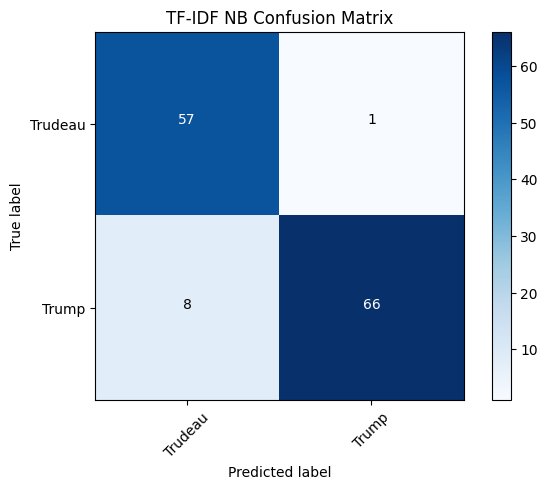

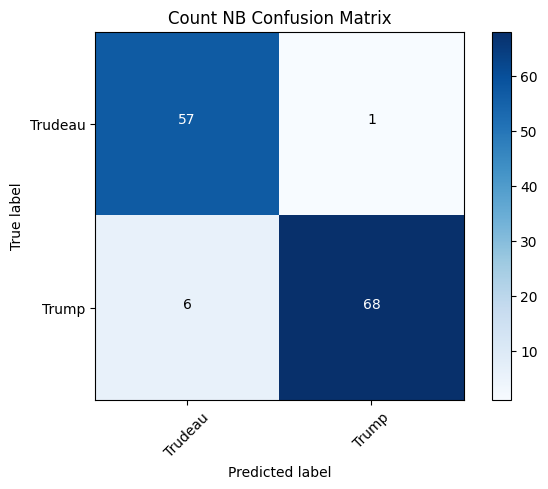

In [ ]:
from sklearn.metrics import confusion_matrix

# Рассчитать матрицы несоответствий для моделей tfidf_nb и count_nb
tfidf_nb_cm = confusion_matrix(y_test, tfidf_nb_pred)
count_nb_cm = confusion_matrix(y_test, count_nb_pred)

# Визуализировать матрицу несоответствий для модели TF-IDF
plot_confusion_matrix(tfidf_nb_cm, classes=['Trudeau', 'Trump'], title="TF-IDF NB Confusion Matrix")

# Визуализировать матрицу несоответствий для модели CountVectorizer (с figure=1, чтобы не перезаписать первый график)
plot_confusion_matrix(count_nb_cm, classes=['Trudeau', 'Trump'], title="Count NB Confusion Matrix", figure=1)

## 6. Пробуем другой классификатор: LinearSVC
<p>Итак, байесовская модель имеет только одно различие в прогнозировании между TF-IDF и векторизаторами подсчета — довольно впечатляюще! Интересно, что возникает некоторая путаница, когда прогнозируемая метка — Трамп, а фактический твиттер — Трюдо. Если бы мы собирались использовать эту модель, мы бы хотели исследовать, какие токены вызывают путаницу, чтобы улучшить модель.</p>
<p>Теперь, когда мы увидели, на что способна байесовская модель, как насчет того, чтобы попробовать другой подход? <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html">LinearSVC</a> — еще один популярный выбор для классификации текста. Посмотрим, улучшит ли его использование с векторами TF-IDF точность классификатора</p>



LinearSVC Score:   0.932
Confusion matrix, without normalization


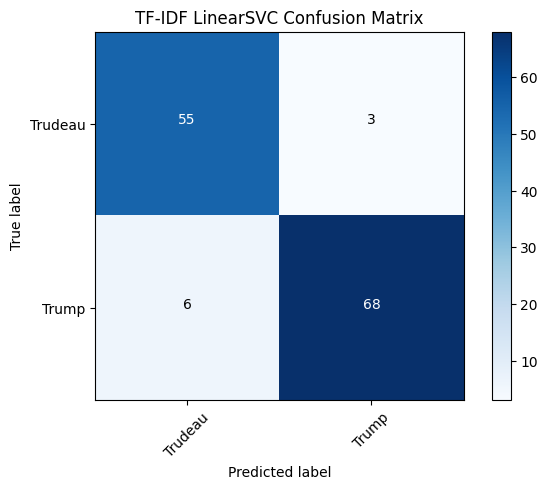

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

# Создать модель LinearSVC
tfidf_svc = LinearSVC(random_state=53)

# Обучить модель на TF-IDF данных
tfidf_svc.fit(tfidf_train, y_train)

# Сделать предсказания на тестовых TF-IDF данных
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

# Рассчитать точность предсказаний
tfidf_svc_score = accuracy_score(y_test, tfidf_svc_pred)

# Вывести точность
print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

# Рассчитать матрицу несоответствий для модели LinearSVC
svc_cm = confusion_matrix(y_test, tfidf_svc_pred)

# Визуализировать матрицу несоответствий
plot_confusion_matrix(svc_cm, classes=['Trudeau', 'Trump'], title="TF-IDF LinearSVC Confusion Matrix")

## 7. Анализ лучшей модели
<p>Модель LinearSVC даже лучше, чем мультиномиальная байесовская. С помощью матрицы несоответствий мы видим, что, хотя все еще есть некоторая путаница, когда твиты Трюдо классифицируются как твиты Трампа, уровень ложных срабатываний лучше, чем в предыдущей модели. Итак, у нас есть производительная модель.</p>
<p>Мы могли бы продолжить настройку и улучшение всех предыдущих моделей, узнав больше об оптимизации параметров или применив более совершенную предварительную обработку твитов. </p>
<p>Теперь посмотрим, чему научилась модель. Используя LinearSVC Classifier с двумя классами (Трамп и Трюдо), мы можем отсортировать признаки (токены) по их весу и увидеть самые важные токены как для Трампа, так и для Трюдо. Какие слова больше всего похожи на Трампа или Трюдо? Узнала ли модель что-то полезное, чтобы различать этих двух политиков? </p>


LinearSVC Score:   0.932
Confusion matrix, without normalization


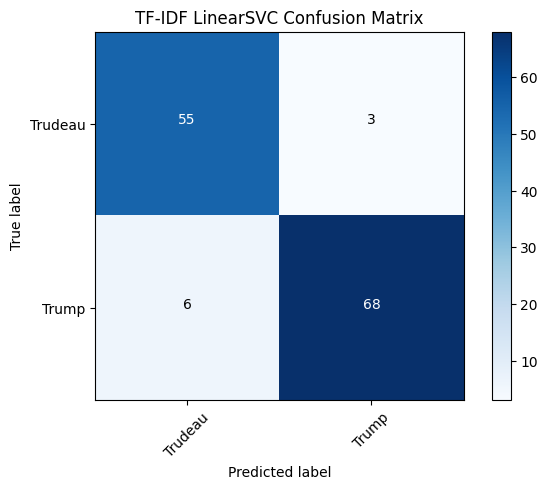

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

# Создать модель LinearSVC
tfidf_svc = LinearSVC(random_state=53)

# Обучить модель на TF-IDF данных
tfidf_svc.fit(tfidf_train, y_train)

# Сделать предсказания на тестовых TF-IDF данных
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

# Рассчитать точность предсказаний
tfidf_svc_score = accuracy_score(y_test, tfidf_svc_pred)

# Вывести точность
print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

# Рассчитать матрицу несоответствий для модели LinearSVC
svc_cm = confusion_matrix(y_test, tfidf_svc_pred)

# Визуализировать матрицу несоответствий
plot_confusion_matrix(svc_cm, classes=['Trudeau', 'Trump'], title="TF-IDF LinearSVC Confusion Matrix")


## 8. Бонус: сможете ли вы написать твит Трампа или Трюдо?
<p>Итак, чему научилась наша модель?</p>
<p>Напишите собственный твит, используя полученные знания, чтобы обмануть модель! Используйте напечатанный список или график выше, чтобы сделать некоторые выводы о том, какие слова классифицируют ваш текст как Трампа или Трюдо. Сможете ли вы обмануть модель, заставив ее думать, что вы Трамп или Трюдо?</p>




In [ ]:
# Напишите два твита
trump_tweet = "America is WINNING again! Great jobs, tremendous economy, and NOBODY does it better than us! #MAGA"
trudeau_tweet = "Together, we’re building a stronger Canada with diversity and opportunity for all. Let’s keep supporting our communities! #TeamCanada"

# Векторизуем каждый твит с помощью метода transform векторизатора TF-IDF
trump_tweet_vectorized = tfidf_vectorizer.transform([trump_tweet])
trudeau_tweet_vectorized = tfidf_vectorizer.transform([trudeau_tweet])

# Сделать предсказания с помощью модели LinearSVC
trump_tweet_pred = tfidf_svc.predict(trump_tweet_vectorized)
trudeau_tweet_pred = tfidf_svc.predict(trudeau_tweet_vectorized)

# Вывести результаты предсказаний
print("Predicted Trump tweet:", trump_tweet_pred)
print("Predicted Trudeau tweet:", trudeau_tweet_pred)

Predicted Trump tweet: ['Donald J. Trump']
Predicted Trudeau tweet: ['Donald J. Trump']


[Текст ссылки](https://)<p>Дальнейшая работа над этим набором данных  может включать:</p>
<ul>
<li>Добавьте дополнительную предварительную обработку (например, удалите URL-адреса или французские стоп-слова) и посмотрите на результаты</li>
<li>Используйте GridSearchCV для улучшения ваших байесовских и линейных SVC-моделей, найдя оптимальные параметры</li>
</ul>

In [ ]:
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import pandas as pd

# Загрузка французских стоп-слов (требуется установка NLTK и загрузка стоп-слов)
import nltk
nltk.download('stopwords')
french_stop_words = stopwords.words('french')
english_stop_words = stopwords.words('english')

# Объединяем английские и французские стоп-слова
combined_stop_words = english_stop_words + french_stop_words

# Функция для очистки текста
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление URL-адресов
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Удаление упоминаний (@username)
    text = re.sub(r'@\w+', '', text)
    # Удаление хэштегов (#hashtag)
    text = re.sub(r'#\w+', '', text)
    # Удаление специальных символов и цифр, оставляем только буквы и пробелы
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Применяем предварительную обработку к данным
tweet_df['status_cleaned'] = tweet_df['status'].apply(preprocess_text)

# Обновляем X и разделяем данные заново
X = tweet_df['status_cleaned']
y = tweet_df['author']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

# Инициализация и векторизация с учетом предварительной обработки
tfidf_vectorizer = TfidfVectorizer(stop_words=combined_stop_words, lowercase=False)  # lowercase уже сделан в preprocess_text
count_vectorizer = CountVectorizer(stop_words=combined_stop_words, lowercase=False)

# Векторизация обучающей и тестовой выборок
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Проверка размеров векторизованных данных
print("Размер tfidf_train после обработки:", tfidf_train.shape)
print("Размер tfidf_test после обработки:", tfidf_test.shape)
print("Размер count_train после обработки:", count_train.shape)
print("Размер count_test после обработки:", count_test.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Размер tfidf_train после обработки: (268, 1518)
Размер tfidf_test после обработки: (132, 1518)
Размер count_train после обработки: (268, 1518)
Размер count_test после обработки: (132, 1518)
